In [11]:
from types import MethodWrapperType, GetSetDescriptorType
from typing import *
from functools import partial
from dataclasses import dataclass

import torch
from torch import Tensor, tensor, nn
from icecream import ic

def numeric_info(dtype):
  return torch.finfo(dtype) if dtype.is_floating_point else torch.iinfo(dtype)

def dtype_max(dtype):
  return numeric_info(dtype).max

def _round(x : Tensor, dtype : torch.dtype) -> Tensor:
  """
  Convert to dtype, rounding if the destination is integer
  """
  if dtype.is_floating_point:
    return x.to(dtype)
  else:
    return torch.round(x).to(dtype)

def function_str(func):
  # https://stackoverflow.com/questions/251464/how-to-get-a-function-name-as-a-string
  # for future expansion e.g. properties
  if hasattr(func, '__module__'):
    return func.__module__ + '.' + func.__qualname__
  else:
    return func.__qualname__

def _uptype(dtype) -> torch.dtype:
    """
    For DTYPE, what is the type in which most arithmetic (e.g. max, abs) is defined?
    """
    GPU = False # Check more accurately, and choose bf16 as appropriate
    f16_t = torch.float16 if GPU else torch.float32
    map = {
        torch.int8: torch.int16,
        torch.int16: torch.int16,
        torch.float8_e4m3fn: f16_t,
        torch.float8_e5m2: f16_t,
        torch.float16: f16_t,
        torch.float32: torch.float32,
    }
    return map[dtype]

def _to_uptype(t : Tensor) -> Tensor:
    """
    Convert t to its _uptype
    """
    return torch.as_tensor(t, dtype=_uptype(t.dtype))


def _maxval(t : Tensor):
    """
    Max absolute value of tensor, returned in its `_uptype`
    """
    return _to_uptype(t).abs().max()

torch.set_printoptions(precision=3, threshold=32)


In [12]:

def tensor_oneline_str(t):
  shape_str = "x".join(map(str, t.shape))
  quantiles = torch.tensor([0, 0.05,.25, .5, .74, 1.0])
  vals = torch.quantile(torch.flatten(t).to(torch.float32), quantiles)
  if t.dtype.is_floating_point:
    # scale down vals
    max = torch.floor(torch.log10(vals.abs().max()))
    if -2 <= max <= 3:
      max = 0
    max_scale = 10 ** -max
    max_scale_str = f"10^{int(max)} x " if max != 0 else ""
    vals_str = max_scale_str + "Quants{" + "|".join(f'{v:.3f}' for v in vals*max_scale) + "}"
  else:
    # Assume integer, print as integers
    vals_str = "Quants{" + "|".join(f'{int(v)}' for v in vals) + "}"

  classname = type(t).__name__

  return f'{classname}({shape_str}) {vals_str}'

for scale in [-10, -3, -2, -1, 0, 1, 2, 3, 10]:
  kurt = 3
  print(tensor_oneline_str(torch.randn(100,300)**kurt*(10**scale)))

print(tensor_oneline_str((torch.randn(100,300) * 10000).to(torch.int16)))


Tensor(100x300) 10^-9 x Quants{-6.477|-0.451|-0.031|-0.000|0.026|8.470}
Tensor(100x300) Quants{-0.064|-0.004|-0.000|0.000|0.000|0.063}
Tensor(100x300) Quants{-0.540|-0.045|-0.003|0.000|0.003|0.675}
Tensor(100x300) Quants{-8.183|-0.450|-0.033|0.000|0.026|6.499}
Tensor(100x300) Quants{-66.096|-4.401|-0.295|0.000|0.274|54.166}
Tensor(100x300) Quants{-733.743|-44.196|-3.178|0.000|2.708|756.593}
Tensor(100x300) Quants{-6929.309|-445.872|-31.348|0.000|26.406|9162.788}
Tensor(100x300) 10^4 x Quants{-5.667|-0.445|-0.030|-0.000|0.026|7.503}
Tensor(100x300) 10^11 x Quants{-7.278|-0.433|-0.030|0.000|0.028|5.738}
Tensor(100x300) Quants{-32675|-16383|-6741|8|6428|32687}


## 1. Core functionality, no syntactic sugar

Define a `ScaleTensorData` object, with the minimal information, and with operations
defined cleanly, but without PyTorch Tensor integration

In [13]:
@dataclass
class ScaledTensorData:
    data: Tensor
    scale: Tensor

    def __post_init__(self) -> None:
        if not isinstance(self.scale, Tensor):
            self.scale = tensor(self.scale)
        assert self.scale.dtype == torch.float32
        assert self.scale.shape == () 
        # Possible future expansion to e.g. row-scaled, column-scaled, etc, but
        # for now, insist st_scale is a single-element tensor

    def __repr__(self) -> str:
        return f"ScaledTensor({self.scale} * {tensor_oneline_str(self.data)})"

    def to_tensor(self, dtype: torch.dtype) -> Tensor:
        return self.data.to(dtype) * self.scale.to(dtype)

    @property
    def shape(self) -> torch.Size:
        return self.data.shape
    
    @property
    def dtype_max(self):
        return dtype_max(self.data.dtype)

def st_quantise(x: Tensor, dtype: torch.dtype) -> ScaledTensorData:
    """
    Rescale so that max(|data|) == maxFinite(data.dtype)

    """
    maxval = _maxval(x)
    if maxval == 0:
        # Tensor is all zeros - set scale to 1
        scale = Tensor(1.0, dtype=torch.float32)
    else:
        # Scale so that largest element is the largest finite value of dtype
        scale = maxval / dtype_max(dtype)

    return ScaledTensorData(_round(x / scale, dtype), scale)


def st_requantise(st: ScaledTensorData) -> ScaledTensorData:
    """
    Rescale so that max(|data|) == maxFinite(data.dtype)

    Equivalent to quantise(st.to_tensor(torch.float32)) but avoids the conversion

    Returned tensor may share its data with input tensor
    """
    maxdataval = _maxval(st.data)
    if maxdataval == 0:
        # All zero, reset scale to 1
        return ScaledTensorData(st.data, st.scale)
    else:
         rescale = maxdataval / st.dtype_max
    return ScaledTensorData((_to_uptype(st.data) * (1 / rescale)).to(st.data.dtype), st.scale * rescale)


def wasted_bits(st_data, maxval = None) -> float:
    """
    By how much is tensor `st_data` not using the full dynamic range of its dtype?

    E.g.
       t = torch.tensor([1,2,-16], dtype=torch.int8)

    Is using only 5 (4 + sign) of the available 8 bits.
    Therefore 
       wasted_bits(t) == 3 == 8-3

    Optional argument maxval, if the maximum value in the tensor has already 
    been computed, perhaps with a higher-accuracy method (e.g. pre-rounding)
    """
    if maxval is None:
        maxval = _maxval(st_data)

    maxval = maxval.to(st_data.dtype)
    dtype_bits = numeric_info(st_data.dtype).bits
    if maxval == 0:
        # All values zero -> all bits are wasted
        return dtype_bits
    
    # Otherwise, how many bits is maxval using.
    if st_data.dtype.is_floating_point:
      # Convert maxval to integer of the same bitwidth
      ints = {
          8: torch.int8,
          16: torch.int16,
          32: torch.int32
      }
      maxval = maxval.view(ints[dtype_bits])

    # Assuming a signed type, max usable bits are dtype_bits-1
    return dtype_bits-1 - torch.log2(maxval)

def test_wasted_bits():
    t = torch.tensor([1,2,-16], dtype=torch.int8)
    assert wasted_bits(t) == 3
test_wasted_bits()

### Quick testing
f16 = tensor([1, 2, 3], dtype=torch.float16)
f8_t = torch.float8_e4m3fn
print(f16)
print(f16.to(f8_t))

st_data = st_quantise(f16, f8_t)

# TODO: wasting a lot more bits at the low end here -- range of 144->448.
print(st_data)
print(f'{wasted_bits(st_data.data)=} <-- of a max of {numeric_info(f8_t).bits} bits, should be wasting nearly zero')
print(st_requantise(st_data))
print(st_data.to_tensor(f16.dtype), "# <- rounding errors at the high end of the f8 range")


tensor([1., 2., 3.], dtype=torch.float16)
tensor([1., 2., 3.], dtype=torch.float8_e4m3fn)
ScaledTensor(0.0066964286379516125 * Tensor(3) Quants{144.000|158.400|216.000|288.000|364.800|448.000})
wasted_bits(st_data.data)=tensor(0.023) <-- of a max of 8 bits, should be wasting nearly zero
ScaledTensor(0.0066964286379516125 * Tensor(3) Quants{144.000|158.400|216.000|288.000|364.800|448.000})
tensor([0.964, 1.928, 3.000], dtype=torch.float16) # <- rounding errors at the high end of the f8 range


## 2. Operators, without syntactic sugar

In [14]:
# Ops
# - Use worst-case scaling rules (no overflow!)
# - Placeholder impl (fast impl requires custom kernels)
# - No autograd support

def st_add(a: ScaledTensorData, b: ScaledTensorData) -> ScaledTensorData:
    out_dtype = a.data.dtype
    scale = a.scale + b.scale
    data = (_to_uptype(a.data) * (a.scale / scale) + _to_uptype(b.data) * (b.scale / scale)).to(out_dtype)
    return ScaledTensorData(data, scale)


def st_matmul(a: ScaledTensorData, b: ScaledTensorData, debug = True) -> ScaledTensorData:
    assert a.data.dtype == b.data.dtype
    in_dtype = a.data.dtype
    out_dtype = a.data.dtype

    a_maxval = a.scale * a.dtype_max
    b_maxval = b.scale * b.dtype_max

    # Predicted maxval for NxK @ KxM
    K = a.shape[-1]
    out_maxval_estimate = a_maxval * b_maxval * K

    out_scale = out_maxval_estimate / dtype_max(out_dtype) 

    # Derivation of matmul scale factors:
    # (ad * as) @ (bd * bs) = (ad @ bd) * (as * bs)
    #                       = (ad @ bd) * (as * bs / os * os)
    #                       = (ad @ bd * as * bs / os) * os
    #                       = (ad @ bd * rat) * os
    #                         where rat = as * bs / os
    #                       = (ad * sqrt(rat)) @ (bd * sqrt(rat)) * os

    rat = a.scale * b.scale / out_scale

    if numeric_info(in_dtype).bits < numeric_info(_uptype(in_dtype)).bits:
        # Assume low-precision muls will accumulate to uptype, so won't overflow
        # to simulate this on cpu, uptype before the matmul;
        # on appropriate hardware (e.g. graphcore, h100), call the special matmul
        adbd = _to_uptype(a.data) @ _to_uptype(b.data)
        if debug:
            out_maxval = _maxval(adbd) * (a.scale * b.scale)
        out_data = adbd * rat
        out_data = out_data.to(out_dtype)
    else:
        # Inputs are in 16+ bits, and we know the products will certainly 
        # overflow, as they are scaled to dtype_max, so downscale before multiplying 
        sqrt_rat = torch.sqrt(rat)
        a_down = _to_uptype(a.data) * sqrt_rat
        b_down = _to_uptype(b.data) * sqrt_rat
        out_data = a_down @ b_down
        if debug:
            out_maxval = _maxval(out_data) * out_scale
        out_data = out_data.to(out_dtype)

    # debug check how bad out_maxval_estimate was
    if debug:
        assert out_maxval_estimate > out_maxval # Should always be an upper bound
        wasted = wasted_bits(out_data)
        if wasted > numeric_info(out_dtype).bits/2:
            print(f'st_matmul: WARNING: Very bad maxval estimate {out_maxval_estimate} vs {out_maxval}, {out_maxval_estimate/out_maxval}x too large - will lose at least {wasted} bits of precision')

        if _maxval(out_data) == 0:
            raise ValueError("All-data zero - rerun with debug and view st_matmul: WARNING above")

    return ScaledTensorData(out_data, out_scale)


def st_relu(a: ScaledTensorData) -> ScaledTensorData:
    data = nn.functional.relu(a.data).to(a.data.dtype)
    return ScaledTensorData(data, a.scale)

# Check operators behae sensibly
st1 = ScaledTensorData(tensor(32, dtype=torch.int8), 0.5)
st2 = ScaledTensorData(tensor(64, dtype=torch.int8), 0.25)

f32 = lambda x: x.to_tensor(torch.float32) if isinstance(x, ScaledTensorData) else x.to(dtype=torch.float32)


ic(st1)
ic(st2)
ic(st_add(st1, st2))
ic(f32(st_add(st1, st2)) )
ic(f32(st1) + f32(st2))

hidden = 32
t3 = torch.randn(2, hidden)
t4 = torch.randn(hidden, 3)
st3 = st_quantise(t3, torch.int8)
st4 = st_quantise(t4, torch.int8)
ic(st3)
ic(st4)
ic(st_matmul(st3, st4))
print(f'{f32(st_matmul(st3, st4)) = } <-- quantized')
print(f'{f32(st3) @ f32(st4) = } <-- intermediate')
print(f'{t3 @ t4 = } <-- exact')

# st5 = st_quantise(tensor([-2, 3, -0.06, 4]), torch.int8)
# ic(st5, f32(st5))
# rt5 = st_relu(st5)
# ic(rt5, f32(rt5))


ic| st1: ScaledTensor(0.5 * Tensor() Quants{32|32|32|32|32|32})


ic| st2: ScaledTensor(0.25 * Tensor() Quants{64|64|64|64|64|64})
ic| st_add(st1, st2): ScaledTensor(0.75 * Tensor() Quants{42|42|42|42|42|42})
ic| f32(st_add(st1, st2)): tensor(31.500)
ic| f32(st1) + f32(st2): tensor(32.)
ic| st3: ScaledTensor(0.024901721626520157 * Tensor(2x32) Quants{-89|-68|-29|5|33|127})
ic| st4: ScaledTensor(0.02432318590581417 * Tensor(32x3) Quants{-115|-67|-19|4|34|127})
ic| st_matmul(st3, st4): ScaledTensor(2.4615209102630615 * Tensor(2x3) Quants{-5|-4|-2|0|1|5})


st_matmul: WARNING: Very bad maxval estimate 312.6131591796875 vs 13.816981315612793, 22.625286102294922x too large - will lose at least 4.678071975708008 bits of precision
st_matmul: WARNING: Very bad maxval estimate 312.6131591796875 vs 13.816981315612793, 22.625286102294922x too large - will lose at least 4.678071975708008 bits of precision
f32(st_matmul(st3, st4)) = tensor([[ -7.385,   0.000,   2.462],
        [ 12.308,   2.462, -12.308]]) <-- quantized
f32(st3) @ f32(st4) = tensor([[ -7.567,  -1.465,   3.374],
        [ 13.817,   3.596, -13.120]]) <-- intermediate
t3 @ t4 = tensor([[ -7.493,  -1.548,   3.283],
        [ 13.791,   3.617, -13.126]]) <-- exact


In [15]:
### [Aside: Possibly surprising rounding]

# print('Starting point: ', tensor([-2, 0.09, 4]))

# st5 = st_quantise(tensor([-2, 0.09, 4]), torch.int8)
# print(f'{st5=} {f32(st5)=} <-- 0.0900 input rounds to 0.0630')

# print('So, put in 0.0630 to begin with')
# st5 = st_quantise(tensor([-2, 0.0630, 4]), torch.int8) 
# print(f'{st5=} {f32(st5)=} <-- great, 0.0630 rounds to 0.0630')

# print('But now, put in 0.06')
# st5 = st_quantise(tensor([-2, 0.06, 4]), torch.int8) 
# print(f'{st5=} {f32(st5)=} <-- Eh, 0.06 rounds down to 0.0315?')


## 3. Sugar hit: override Tensor operations in subclass

We define a `ScaledTensor` object that behaves like a torch Tensor.

In [54]:
# See https://pytorch.org/docs/stable/notes/extending.html#extending-torch-with-a-tensor-like-type
# TODO: check _make_wrapper_subclass
class ScaledTensor(Tensor):
    def __init__(self, st_data : ScaledTensorData):
        super().__init__()
        self.st = st_data
        
    def __new__(cls, st_data, *args, **kwargs):
        # Ensure that if the tensor is ever viewed as the base class, it is NaN
        tensor_data = tensor(torch.nan)
        return super().__new__(cls, tensor_data, *args, **kwargs)

    def __repr__(self) -> str:
        # See https://github.com/pytorch/pytorch/issues/73665
        with torch._C.DisableTorchFunctionSubclass():
            return f"<{super().__repr__()} where nan={self.st}>"

    @property
    def shape(self) -> torch.Size:
        return self.st.shape

    def size(self) -> torch.Size:
        return self.st.shape

    def requires_grad_(self, val):
        with torch._C.DisableTorchFunctionSubclass():
            return super().requires_grad_(val)
            
    def detach(self) -> Tensor:
        return ScaledTensor(ScaledTensorData(self.st.data.detach(), self.st.scale))

    @classmethod
    def __torch_function__(cls, func, types, args=(), kwargs=None):
        kwargs = kwargs or {}
        # Have we registered a handler?
        # 1. Turn "func" into something we can lookup in the HANDLED_FUNCTIONS dict.
        if isinstance(func, MethodWrapperType):
            # For methods, e.g. Tensor.T, we want to use that name, so unpack it
            assert func.__qualname__ == 'getset_descriptor.__get__' # This is the only case tested so far
            func_to_lookup = func.__self__
        else:
            # Probably other special cases here
            func_to_lookup = func

        # 2. Is this one we handle?
        if func_to_lookup in cls.HANDLED_FUNCTIONS:
          ret = cls.HANDLED_FUNCTIONS[func_to_lookup](*args, **kwargs)
          # handler may return "NotImplemented" to tell us to run the fallback
          if ret != NotImplemented:
              return ret
          # Otherwise drop through to the fallback

        # 3. Fallback: Convert to float32 and call func
        print(f"ScaledTensor.__torch_function__: WARNING: Upcasting to float32 for {function_str(func_to_lookup)}@{types}")

        def to_tensor_if_scaled(t : Any) -> Tensor:
            if isinstance(t, ScaledTensor):
                return t.st.to_tensor(torch.float32)
            else:
                return t

        new_args = tuple(to_tensor_if_scaled(a) for a in args)
        new_kwargs = { k:to_tensor_if_scaled(v) for (k,v) in kwargs.items() }

        # To call the default implementation, docs suggest we call
        #    ret = super().__torch_function__(func, types, new_args, new_kwargs)
        # but the super()'s handler will forcibly downcast the result to ScaledTensor
        # which is wrong - they are not ScaledTensors.  Just return what was computed.
        with torch._C.DisableTorchFunctionSubclass():
            return func(*new_args, **new_kwargs)

ScaledTensor.HANDLED_FUNCTIONS = {}

# Forward the ScaledTensorData ops above on the ScaledTensor type
def quantise(x: Tensor, dtype: torch.dtype) -> ScaledTensor:
    return ScaledTensor(st_quantise(x, dtype))

def requantise(st) -> ScaledTensor:
    return ScaledTensor(st_requantise(st.st))

# Check basic to/from Subclass
f16 = tensor([1, 2, 3], dtype=torch.float16)
f8_t = torch.int8
print(f16)
print(f16.to(f8_t))

st = quantise(f16, f8_t)

print(st)
print(requantise(st))
print('Rounding errors at the high end of the f8 range:', st.st.to_tensor(f16.dtype))
print('Viewing as a tensor should show NaN:', Tensor(st))

print('Reshaped, but upscaled to f32:', st.T)

st.requires_grad_(True)


tensor([1., 2., 3.], dtype=torch.float16)
tensor([1, 2, 3], dtype=torch.int8)
<ScaledTensor(nan) where nan=ScaledTensor(0.023622047156095505 * Tensor(3) Quants{42|46|63|85|105|127})>
<ScaledTensor(nan) where nan=ScaledTensor(0.023622047156095505 * Tensor(3) Quants{42|46|63|85|105|127})>
Rounding errors at the high end of the f8 range: tensor([0.992, 2.008, 3.000], dtype=torch.float16)
Viewing as a tensor should show NaN: tensor(nan)
ScaledTensor.__torch_function__: WARNING: Upcasting to float32 for _TensorBase.T@(<class '__main__.ScaledTensor'>,)
Reshaped, but upscaled to f32: tensor([0.992, 2.008, 3.000])


<ScaledTensor(nan, requires_grad=True) where nan=ScaledTensor(0.023622047156095505 * Tensor(3) Quants{42|46|63|85|105|127})>

### Now overrides work, but just punt up to f32 for all ops

We will do some adds/multiplies etc, and note that the torch function
implementation issues a sequence of "WARNING: Upcasting to float32"

In [39]:
print(st + 2)
print(2 * st)
print(st + st)

st3 = quantise(torch.full((2, 3), 100.0), torch.int8)
st4 = quantise(torch.full((3, 4), 200.0), torch.int8)

print(f'{f32(st3 @ st4)       = } <-- should be ~48200 quantized, but was done in f32 so exact')
print(f'{f32(st3) @ f32(st4)  = } <-- 60000 exact')

m16 = quantise(tensor([[1, 2, 3], [4, 5, 6]], dtype=torch.float16), f8_t)

print('Reshaped, but upscaled to f32:', m16.T)


ScaledTensor.__torch_function__: WARNING: Upcasting to float32 for _TensorBase.add@(<class '__main__.ScaledTensor'>,)
tensor([2.992, 4.008, 5.000])
ScaledTensor.__torch_function__: WARNING: Upcasting to float32 for _TensorBase.mul@(<class '__main__.ScaledTensor'>,)
tensor([1.984, 4.016, 6.000])
ScaledTensor.__torch_function__: WARNING: Upcasting to float32 for _TensorBase.add@(<class '__main__.ScaledTensor'>,)
tensor([1.984, 4.016, 6.000])
ScaledTensor.__torch_function__: WARNING: Upcasting to float32 for _TensorBase.matmul@(<class '__main__.ScaledTensor'>,)
f32(st3 @ st4)       = tensor([[60000., 60000., 60000., 60000.],
        [60000., 60000., 60000., 60000.]]) <-- should be ~48200 quantized, but was done in f32 so exact
ScaledTensor.__torch_function__: WARNING: Upcasting to float32 for _TensorBase.to@(<class '__main__.ScaledTensor'>,)
ScaledTensor.__torch_function__: WARNING: Upcasting to float32 for _TensorBase.to@(<class '__main__.ScaledTensor'>,)
f32(st3) @ f32(st4)  = tensor([[

In [41]:
def torch_function_override(cls, funcs):
    funcs = funcs if isinstance(funcs, tuple) else (funcs,)

    def doit(impl):
        # This work is also done by functools.wraps, but it doesn't make sensible names,
        # and doesn't fix qualname
        if not hasattr(impl,"__name__"):
            pass
        else:
          if impl.__name__ == '_':
              impl.__name__ = f'@torch_function_override({cls.__name__}, {funcs})'
              if impl.__qualname__ != '_':
                  print(f'torch_function_override: NOTE: {impl.__qualname__} not overridden')
          if impl.__qualname__ == '_':
              impl.__qualname__ = f'torch_function_override({cls.__name__}, {funcs})'
          else:
              pass

        # Record it in the dictionary
        for func in funcs:
          cls.HANDLED_FUNCTIONS[func] = impl

    return doit

@torch_function_override(ScaledTensor, Tensor.add)
def _(a:Tensor, b: Tensor) -> Tensor:
    if not (isinstance(a, ScaledTensor) and isinstance(b, ScaledTensor)):
        print(f'ScaledTensor: Punting on {type(a), type(b)=}')
        return NotImplemented

    return ScaledTensor(st_add(a.st, b.st))

@torch_function_override(ScaledTensor, Tensor.matmul)
def _(a:Tensor, b: Tensor) -> Tensor:
    if not (isinstance(a, ScaledTensor) and isinstance(b, ScaledTensor)):
        return NotImplemented

    return ScaledTensor(st_matmul(a.st, b.st))

@torch_function_override(ScaledTensor, Tensor.to)
def _(a:Tensor, dtype:torch.dtype) -> Tensor:
    assert isinstance(a, ScaledTensor)
    return a.st.to_tensor(dtype)

@torch_function_override(ScaledTensor, (Tensor.relu, nn.functional.relu))
def _(a:Tensor, inplace = False) -> Tensor:
    assert isinstance(a, ScaledTensor)
    assert not inplace
    return ScaledTensor(st_relu(a.st))

## Override reshaping operations
def reshape_passthru(func, a:Tensor, *args, **kwargs) -> Tensor:
    assert isinstance(a, ScaledTensor)
    func_to_call = func.__get__ if isinstance(func, GetSetDescriptorType) else func
    st_data = func_to_call(a.st.data, *args, **kwargs)
    return ScaledTensor(ScaledTensorData(st_data, a.st.scale))

for func in (Tensor.T, Tensor.flatten, torch.flatten):
    print(function_str(func))
    torch_function_override(ScaledTensor, func)(partial(reshape_passthru, func))

ic(st3)
ic(st3.T)
ic(st3.flatten())
ic(torch.flatten(st3))

ic(st4)
ic(st3 @ st4 )
print(f'{f32(st3 @ st4)       = } <-- ~48200 quantized')
print(f'{f32(st3) @ f32(st4)  = } <-- 60000 exact')

print(nn.functional.relu(st))



ic| st3: ScaledTensor(0.787401556968689 * Tensor(2x3) Quants{127|127|127|127|127|127})
ic| st3.T: ScaledTensor(0.787401556968689 * Tensor(3x2) Quants{

_TensorBase.T
_TensorBase.flatten
torch._VariableFunctionsClass.flatten


127|127|127|127|127|127})
ic| st3.flatten(): ScaledTensor(0.787401556968689 * Tensor(6) Quants{127|127|127|127|127|127})
ic| torch.flatten(st3): ScaledTensor(0.787401556968689 * Tensor(6) Quants{127|127|127|127|127|127})
ic| st4: ScaledTensor(1.574803113937378 * Tensor(3x4) Quants{127|127|127|127|127|127})
ic| st3 @ st4: ScaledTensor(472.4409484863281 * Tensor(2x4) Quants{-45|-45|-45|-45|-45|-45})


f32(st3 @ st4)       = tensor([[-21259.842, -21259.842, -21259.842, -21259.842],
        [-21259.842, -21259.842, -21259.842, -21259.842]]) <-- ~48200 quantized
f32(st3) @ f32(st4)  = tensor([[60000., 60000., 60000., 60000.],
        [60000., 60000., 60000., 60000.]]) <-- 60000 exact
ScaledTensor(0.023622047156095505 * Tensor(3) Quants{42|46|63|85|105|127})
ScaledTensor.__torch_function__: WARNING: Upcasting to float32 for _TensorBase.requires_grad_@(<class '__main__.ScaledTensor'>,)


tensor([0.992, 2.008, 3.000], requires_grad=True)

# And in a network...

In [19]:
# Example
from icecream import ic

class FFN(nn.Module):
    def __init__(self, hidden_size: int, dtype: torch.dtype):
        super().__init__()
        q = lambda x: quantise(x, dtype)
        self.W0 = q(torch.randn(hidden_size, 4*hidden_size))
        self.W1 = q(torch.randn(4*hidden_size, hidden_size))
        ic(self.W1)

    def forward(self, x: Union[Tensor, ScaledTensor]) -> Union[Tensor, ScaledTensor]:
        y = nn.functional.relu(x @ self.W0)

        if isinstance(y, ScaledTensor):
            print(f"wasted bits #1: {wasted_bits(y)}")
            y = requantise(y)

        y = y @ self.W1

        if isinstance(y, ScaledTensor):
            print(f"wasted bits #2: {wasted_bits(y)}")

        return y

hidden_size = 1024
storage_type = torch.int8
module = FFN(hidden_size, storage_type)
x = quantise(torch.randn(10, hidden_size), storage_type)
result = module(x)
print()
print(result)

ic| self.W1: ScaledTensor(0.04146788641810417 * Tensor(4096x1024) Quants{-127|-40|-16|0|16|126})


st_matmul: WARNING: Very bad maxval estimate 21791.580078125 vs 43.23326110839844, 504.046630859375x too large - will lose at least 8 bits of precision


ValueError: All-data zero - rerun with debug and view st_matmul: WARNING above

## CIFAR

Files already downloaded and verified
Files already downloaded and verified


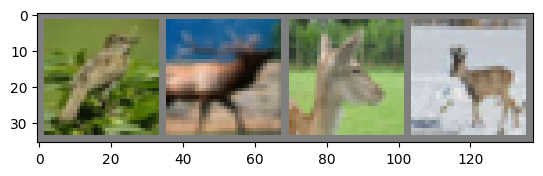

bird  deer  deer  deer 


In [58]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [59]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

for n,p in net.named_parameters():
  print(n,tensor_oneline_str(p))

d = net.state_dict()
for k in d:
  d[k] = quantise(d[k], torch.int16)

net.load_state_dict(d, assign=True)

print()
print("Post quantisation")
print("=================")
for n,p in net.named_parameters():
  print(n,p)



conv1.weight Parameter(6x3x5x5) Quants{-0.115|-0.106|-0.057|0.002|0.062|0.115}
conv1.bias Parameter(6) Quants{-0.088|-0.071|-0.014|0.012|0.020|0.034}
conv2.weight Parameter(16x6x5x5) Quants{-0.082|-0.073|-0.039|0.002|0.041|0.082}
conv2.bias Parameter(16) Quants{-0.081|-0.072|-0.021|0.015|0.042|0.078}
fc1.weight Parameter(120x400) Quants{-0.050|-0.045|-0.025|-0.000|0.024|0.050}
fc1.bias Parameter(120) Quants{-0.050|-0.044|-0.028|-0.004|0.023|0.049}
fc2.weight Parameter(84x120) Quants{-0.091|-0.082|-0.046|0.000|0.044|0.091}
fc2.bias Parameter(84) Quants{-0.087|-0.079|-0.055|0.001|0.034|0.085}
fc3.weight Parameter(10x84) Quants{-0.109|-0.096|-0.054|0.006|0.054|0.109}
fc3.bias Parameter(10) Quants{-0.077|-0.050|0.019|0.065|0.084|0.102}
ScaledTensor.__torch_function__: WARNING: Upcasting to float32 for _TensorBase.grad_fn@(<class '__main__.ScaledTensor'>,)
ScaledTensor.__torch_function__: WARNING: Upcasting to float32 for _TensorBase.grad_fn@(<class '__main__.ScaledTensor'>,)
ScaledTensor._

In [60]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

ScaledTensor.__torch_function__: WARNING: Upcasting to float32 for _TensorBase.is_leaf@(<class '__main__.ScaledTensor'>,)
ScaledTensor.__torch_function__: WARNING: Upcasting to float32 for _TensorBase.is_leaf@(<class '__main__.ScaledTensor'>,)
ScaledTensor.__torch_function__: WARNING: Upcasting to float32 for _TensorBase.is_leaf@(<class '__main__.ScaledTensor'>,)
ScaledTensor.__torch_function__: WARNING: Upcasting to float32 for _TensorBase.is_leaf@(<class '__main__.ScaledTensor'>,)
ScaledTensor.__torch_function__: WARNING: Upcasting to float32 for _TensorBase.is_leaf@(<class '__main__.ScaledTensor'>,)
ScaledTensor.__torch_function__: WARNING: Upcasting to float32 for _TensorBase.is_leaf@(<class '__main__.ScaledTensor'>,)
ScaledTensor.__torch_function__: WARNING: Upcasting to float32 for _TensorBase.is_leaf@(<class '__main__.ScaledTensor'>,)
ScaledTensor.__torch_function__: WARNING: Upcasting to float32 for _TensorBase.is_leaf@(<class '__main__.ScaledTensor'>,)
ScaledTensor.__torch_fun

In [61]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 0:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

ScaledTensor.__torch_function__: WARNING: Upcasting to float32 for _TensorBase.grad@(<class '__main__.ScaledTensor'>,)
ScaledTensor.__torch_function__: WARNING: Upcasting to float32 for _TensorBase.grad@(<class '__main__.ScaledTensor'>,)
ScaledTensor.__torch_function__: WARNING: Upcasting to float32 for _TensorBase.grad@(<class '__main__.ScaledTensor'>,)
ScaledTensor.__torch_function__: WARNING: Upcasting to float32 for _TensorBase.grad@(<class '__main__.ScaledTensor'>,)
ScaledTensor.__torch_function__: WARNING: Upcasting to float32 for _TensorBase.grad@(<class '__main__.ScaledTensor'>,)
ScaledTensor.__torch_function__: WARNING: Upcasting to float32 for _TensorBase.grad@(<class '__main__.ScaledTensor'>,)
ScaledTensor.__torch_function__: WARNING: Upcasting to float32 for _TensorBase.grad@(<class '__main__.ScaledTensor'>,)
ScaledTensor.__torch_function__: WARNING: Upcasting to float32 for _TensorBase.grad@(<class '__main__.ScaledTensor'>,)
ScaledTensor.__torch_function__: WARNING: Upcast

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn